In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr

import torch
import gpytorch
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
from gpytorch.distributions import MultivariateNormal

import tqdm

# Tasks

Tasks:
- compare kernels
- zero mean
- other mean

Evaluation
- diagonal slice for 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
byrd_bedmap_points = pd.read_csv('/home/kim/ice_thickness/data/byrd_bedmap_points_clean.csv')
byrd_bedmap_points_pixel = pd.read_csv('/home/kim/ice_thickness/data/byrd_bedmap_points_assigned_to_pixels_mean.csv')

byrd_bedmap_points_pixel

,Unnamed: 0,center_index,t_mean,t_std,t_count,t_sem,t_sem_check,x,y
0,0,350000_-980000,95.892778,5.365275,18,1.264607,1.264607,350000,-980000
1,1,350000_-990500,640.070000,NaN,1,NaN,NaN,350000,-990500
2,2,350000_-991000,670.948182,17.315805,11,5.220912,5.220912,350000,-991000
3,3,350000_-999000,744.478000,3.212053,10,1.015740,1.015740,350000,-999000
4,4,350500_-980000,88.767143,3.491351,35,0.590146,0.590146,350500,-980000
...,...,...,...,...,...,...,...,...,...
26910,26910,549500_-931000,1814.238750,6.377909,8,2.254931,2.254931,549500,-931000
26911,26911,549500_-931500,1841.431818,11.084475,11,3.342095,3.342095,549500,-931500
26912,26912,549500_-972500,2167.790000,2.540020,9,0.846673,0.846673,549500,-972500
26913,26913,549500_-997500,1115.707500,6.228084,4,3.114042,3.114042,549500,-997500


In [4]:
N_size = 5000
N_induce = 500

train_x = torch.tensor(np.array(byrd_bedmap_points_pixel[["x", "y"]]).astype(int)/1000000, dtype = torch.float32)
# generate random order
order = torch.randperm(train_x.size()[0])
# reorder and select first N_size
train_x = train_x[order][:N_size].to(device)

train_y = torch.tensor(np.array(byrd_bedmap_points_pixel[["t_mean"]]), dtype = torch.float32)
train_y = train_y[order][:N_size, 0].to(device)

print(train_x.shape)
print(train_y.shape)

# train_x_small = train_x[:1000].to(device)
# train_y_small = train_x[:1000].to(device)

torch.Size([5000, 2])
torch.Size([5000])


In [5]:
initial_inducing_points = train_x[:N_induce]

# Sparse Gaussian Process Model (SGPR) (inducing point kernel)

Scalable kernel approximations.

Sparse Gaussian Process Regression (SGPR) (proposed by Titsias, 2009) which approximates kernels using a set of inducing points. This is a general purpose approximation

- scaled RBF kernel as base kernel
- wraped in
- https://docs.gpytorch.ai/en/stable/kernels.html#kernels-for-scalable-gp-regression-methods 
    - Documentation (missing): https://docs.gpytorch.ai/en/stable/kernels.html#gpytorch.kernels.InducingPointKernel
    - Source code: https://docs.gpytorch.ai/en/stable/_modules/gpytorch/kernels/inducing_point_kernel.html#InducingPointKernel

In [6]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        # CONSTANT MEAN
        self.mean_module = ConstantMean()
        # RBF KERNEL WITH ARD
        self.base_covar_module = ScaleKernel(RBFKernel(ard_num_dims = 2))
        # INDUCING POINTS
        # Randomly selects 500 first points from the training data (x locations?!)
        # Initialise Inducing points (this is a parameter)
        self.covar_module = InducingPointKernel(self.base_covar_module, inducing_points = initial_inducing_points, likelihood = likelihood)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [7]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood)

# Put on cuda
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

In [8]:
training_iterations = 1000

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def train():
    iterator = tqdm.tqdm(range(training_iterations), desc = "Train")

    for i in iterator:
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calc loss and backprop derivatives
        loss = - mll(output, train_y)
        loss.backward()
        iterator.set_postfix(loss = loss.item())
        optimizer.step()
        torch.cuda.empty_cache()

%time train()

Train:   0%|          | 0/1000 [00:00<?, ?it/s]/home/kim/ice_thickness/.conda/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/kim/ice_thickness/.conda/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
Train:  31%|███▏      | 314/1000 [00:07<00:16, 42.71it/s, loss=4.38e+4]/home/kim/ice_thickness/.conda/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
Train:  74%|███████▍  | 745/1000 [00:18<00:06, 40.99it/s, loss=2.47e+4]


NotPSDError: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.

In [12]:
for name, param in model.named_parameters():
    print(f"Parameter name: {name}")
    print(f"Parameter value: {param}")
    print(f"Requires gradient: {param.requires_grad}")
    print("-----------------------------")

Parameter name: likelihood.noise_covar.raw_noise
Parameter value: Parameter containing:
tensor([3.0658], device='cuda:0', requires_grad=True)
Requires gradient: True
-----------------------------
Parameter name: mean_module.raw_constant
Parameter value: Parameter containing:
tensor(11.0032, device='cuda:0', requires_grad=True)
Requires gradient: True
-----------------------------
Parameter name: base_covar_module.raw_outputscale
Parameter value: Parameter containing:
tensor(6.9911, device='cuda:0', requires_grad=True)
Requires gradient: True
-----------------------------
Parameter name: base_covar_module.base_kernel.raw_lengthscale
Parameter value: Parameter containing:
tensor([[-3.6846, -3.0740]], device='cuda:0', requires_grad=True)
Requires gradient: True
-----------------------------
Parameter name: covar_module.inducing_points
Parameter value: Parameter containing:
tensor([[ 5.8962e-01, -7.2969e-01],
        [ 2.5517e-01, -3.5745e-01],
        [ 4.8758e-01, -9.9898e-01],
        [

# Learns inducing point locations

# Issue

Inducing point did not move

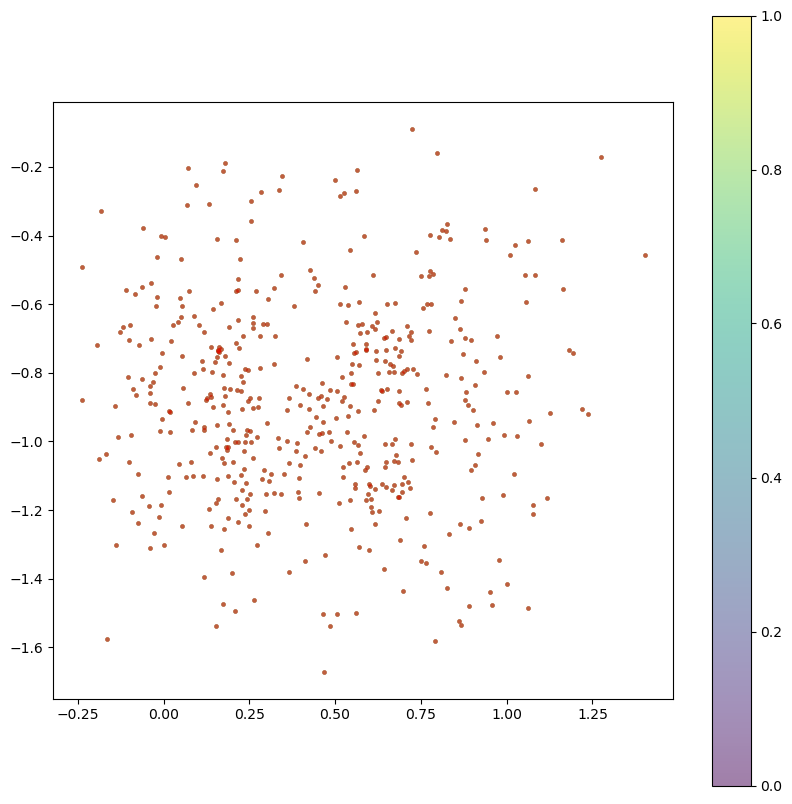

In [13]:
# XX, YY = np.meshgrid(byrd_bedmachine.x, byrd_bedmachine.y)

fig, ax = plt.subplots(figsize = (10, 10))

# Plot bed topography mesh
# ax.pcolormesh(XX, YY, byrd_bedmachine.thickness_ellipsoid_true, cmap = icethickness_cmap, vmin = 0, vmax = 3500)

# Plot data points
ax.scatter(initial_inducing_points[:, 0].cpu().detach().numpy(), 
           initial_inducing_points[:, 1].cpu().detach().numpy(), 
           c = "green", 
           alpha = 0.5,
           s = 10,
           edgecolors = "green",
           linewidth = 0.15)

ax.scatter(model.covar_module.inducing_points[:, 0].cpu().detach().numpy(), 
           model.covar_module.inducing_points[:, 1].cpu().detach().numpy(), 
           c = "red", 
           s = 10,
           alpha = 0.5,
           edgecolors = "red",
           linewidth = 0.15)

fig.colorbar(mappable = ax.collections[0], ax = ax)
ax.set_aspect('equal')

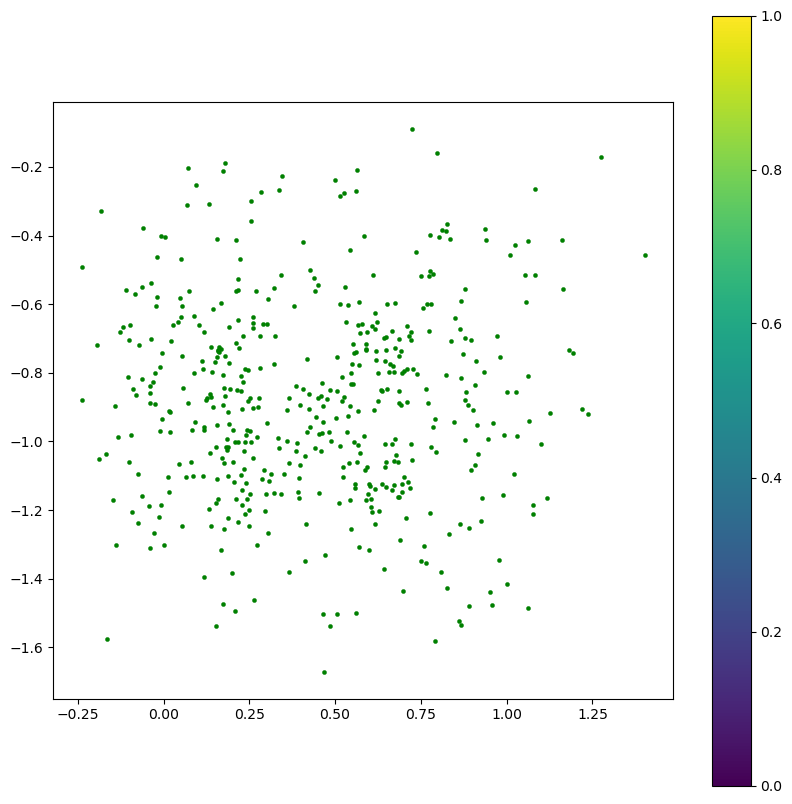

In [14]:
# XX, YY = np.meshgrid(byrd_bedmachine.x, byrd_bedmachine.y)

fig, ax = plt.subplots(figsize = (10, 10))

# Plot bed topography mesh
# ax.pcolormesh(XX, YY, byrd_bedmachine.thickness_ellipsoid_true, cmap = icethickness_cmap, vmin = 0, vmax = 3500)

# Plot data points
ax.scatter(initial_inducing_points[:, 0].cpu().detach().numpy(), 
           initial_inducing_points[:, 1].cpu().detach().numpy(), 
           c = "green", 
           s = 10,
           edgecolors = "green",
           linewidth = 0.15)


fig.colorbar(mappable = ax.collections[0], ax = ax)
ax.set_aspect('equal')